In [1]:
from collections import OrderedDict
from copy import deepcopy

import seaborn as sns
import matplotlib.pyplot as plt

import simuPOP as sp
%matplotlib inline

simuPOP Version 1.1.8.3 : Copyright (c) 2004-2016 Bo Peng
Revision 4553 (Feb 11 2017) for Python 3.6.0 (64bit, 1thread)
Random Number Generator is set to mt19937 with random seed 0xec19ecf015ece069.
This is the standard short allele version with 256 maximum allelic states.
For more information, please visit http://simupop.sourceforge.net,
or email simupop-list@lists.sourceforge.net (subscription required).


In [2]:
num_loci = 10
pop_size = 1000
num_gens = 101

In [3]:
init_ops = OrderedDict()
pre_ops = OrderedDict()
post_ops = OrderedDict()

In [4]:
def init_accumulators(pop, param):
    accumulators = param
    for accumulator in accumulators:
        pop.vars()[accumulator] = []
    return True

def update_accumulator(pop, param):
    accumulator, var = param
    pop.vars()[accumulator].append(deepcopy(pop.vars()[var]))
    return True

In [5]:
pops = sp.Population(pop_size, loci=[1] * num_loci, infoFields=['fitness'])

In [6]:
def create_derived_by_count(pop, param):
    #Assumes everything is autosomal and that derived is low (<0.5)
    locus, cnt = param
    for i, ind in enumerate(pop.individuals()):
        for marker in range(pop.totNumLoci()):
            if i < cnt and locus == marker:
                ind.setAllele(1, marker, 0)
            else:
                ind.setAllele(0, marker, 0)
            ind.setAllele(0, marker, 1)
    return True

In [7]:
init_ops['Sex'] = sp.InitSex()
init_ops['Freq-sel'] = sp.PyOperator(create_derived_by_count, param=(0, 10))
#careful above
init_ops['Freq-neutral'] = sp.InitGenotype(freq=[0.5, 0.5], loci=range(1, num_loci))
post_ops['Stat-freq'] = sp.Stat(alleleFreq=sp.ALL_AVAIL)
post_ops['Stat-freq-eval'] = sp.PyEval(r"'%d %.3f\n' % (gen, alleleFreq[0][1])", reps=[0], step=10)

In [8]:
ms = sp.MapSelector(loci=0, fitness={
                (0, 0): 0.90,
                (0, 1): 1,
                (1, 1): 1})
pre_ops['Selection'] = ms
mating_scheme = sp.RandomMating()

In [9]:
def get_freq_deriv(pop, param):
    marker, name = param
    expHe = {}
    pop.vars()[name] = pop.dvars().alleleFreq[marker][1]
    return True

In [10]:
init_ops['accumulators'] = sp.PyOperator(init_accumulators, param=['freq_sel'])
post_ops['FreqSel'] = sp.PyOperator(get_freq_deriv, param=(0, 'freqDeriv'))
post_ops['freq_sel_accumulation'] = sp.PyOperator(update_accumulator, param=('freq_sel', 'freqDeriv'))

In [11]:
sim = sp.Simulator(pops, rep=100)  # talk about threads
sim.evolve(initOps=list(init_ops.values()), preOps=list(pre_ops.values()), postOps=list(post_ops.values()),
           matingScheme=mating_scheme, gen=num_gens)
None

0 0.006
10 0.015
20 0.044
30 0.123
40 0.226
50 0.341
60 0.507
70 0.624
80 0.673
90 0.780
100 0.838


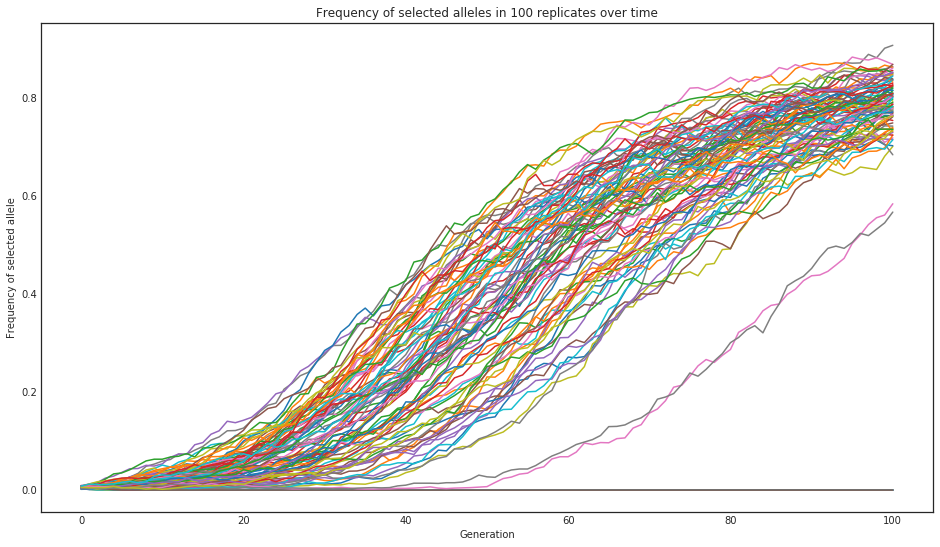

In [12]:
sns.set_style('white')
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
ax.set_title('Frequency of selected alleles in 100 replicates over time')
ax.set_xlabel('Generation')
ax.set_ylabel('Frequency of selected allele')
for pop in sim.populations():
    ax.plot(pop.vars()['freq_sel'])

In [13]:
pop_size = 100
pops = sp.Population(pop_size, loci=[1] * num_loci, infoFields=['fitness'])

In [14]:
#XXX change
init_ops['Freq-sel'] = sp.PyOperator(create_derived_by_count, param=(0, 1))
sim = sp.Simulator(pops, rep=100)  # talk about threads
sim.evolve(initOps=list(init_ops.values()), preOps=list(pre_ops.values()), postOps=list(post_ops.values()),
           matingScheme=mating_scheme, gen=num_gens)
None

0 0.010
10 0.080
20 0.205
30 0.270
40 0.445
50 0.490
60 0.585
70 0.640
80 0.720
90 0.790
100 0.895


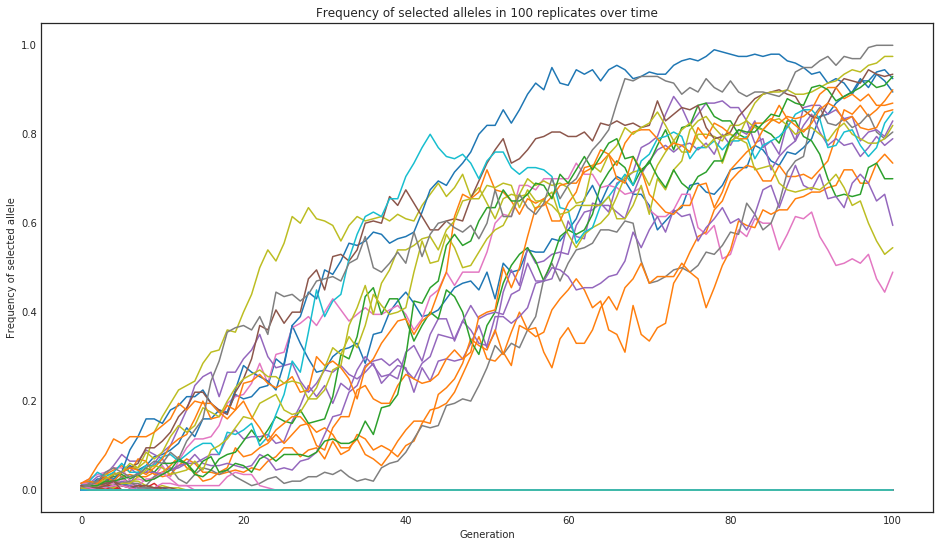

In [15]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
ax.set_xlabel('Generation')
ax.set_ylabel('Frequency of selected allele')
ax.set_title('Frequency of selected alleles in 100 replicates over time')
for pop in sim.populations():
    ax.plot(pop.vars()['freq_sel'])

In [16]:
#suggest comparing with neutral

In [17]:
hz_ms = sp.MapSelector(loci=0, fitness={
                (0, 0): 0.9,
                (0, 1): 0.9,
                (1, 1): 1})
hz_mating_scheme = sp.RandomMating(ops=[sp.MendelianGenoTransmitter(), hz_ms])

In [18]:
recessive_ms = sp.MapSelector(loci=0, fitness={
                (0, 0): 0.9,
                (0, 1): 0.9,
                (1, 1): 1})
recessive_mating_scheme = sp.RandomMating(ops=[sp.MendelianGenoTransmitter(), recessive_ms])

In [19]:
# talk about multi-loci

In [20]:
pop_size = 5000
num_gens = 100
pops = sp.Population(pop_size, loci=[1] * num_loci, infoFields=['fitness'])

In [21]:
def example_epistasis(geno):
    if geno[0] + geno[1] == 0:
        return 0.7
    elif geno[2] + geno[3] == 0:
        return 0.8
    else:
        return 0.9 + 0.1 * (geno[2] + geno[3] - 1)

In [22]:
init_ops = OrderedDict()
pre_ops = OrderedDict()
post_ops = OrderedDict()
init_ops['Sex'] = sp.InitSex()
init_ops['Freq-sel'] = sp.InitGenotype(freq=[0.99, 0.01], loci=[0, 1])
init_ops['Freq-neutral'] = sp.InitGenotype(freq=[0.5, 0.5], loci=range(2, num_loci))
pre_ops['Selection'] = sp.PySelector(loci=[0, 1], func=example_epistasis)
init_ops['accumulators'] = sp.PyOperator(init_accumulators, param=['freq_sel_major', 'freq_sel_minor'])
post_ops['Stat-freq'] = sp.Stat(alleleFreq=sp.ALL_AVAIL)
post_ops['FreqSelMajor'] = sp.PyOperator(get_freq_deriv, param=(0, 'FreqSelMajor'))
post_ops['FreqSelMinor'] = sp.PyOperator(get_freq_deriv, param=(1, 'FreqSelMinor'))
post_ops['freq_sel_major_accumulation'] = sp.PyOperator(update_accumulator,
                                                        param=('freq_sel_major', 'FreqSelMajor'))
post_ops['freq_sel_minor_accumulation'] = sp.PyOperator(update_accumulator,
                                                        param=('freq_sel_minor', 'FreqSelMinor'))

In [23]:
#XXX change
sim = sp.Simulator(pops, rep=15)
sim.evolve(initOps=list(init_ops.values()), preOps=list(pre_ops.values()), postOps=list(post_ops.values()),
           matingScheme=mating_scheme, gen=num_gens)
None

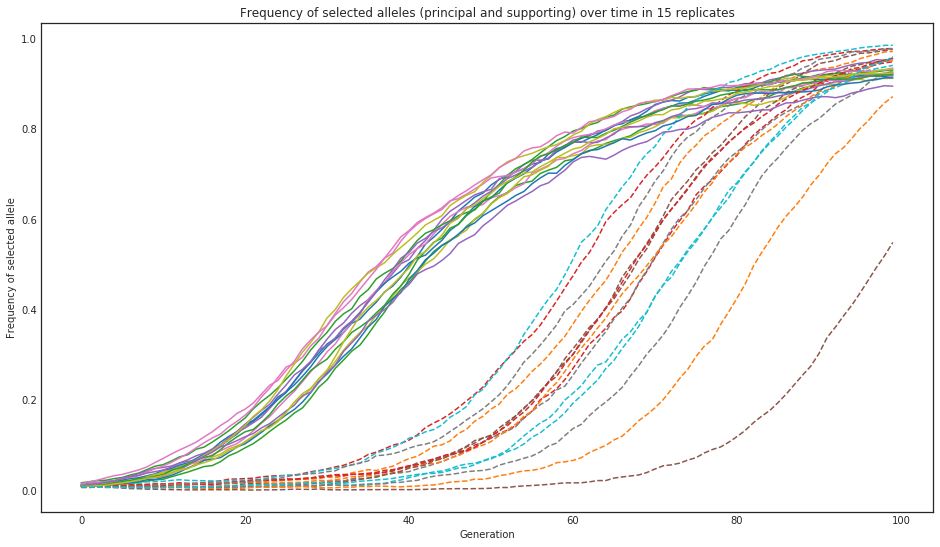

In [26]:
fig = plt.figure(figsize=(16, 9))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Generation')
ax1.set_ylabel('Frequency of selected allele')
ax1.set_title('Frequency of selected alleles (principal and supporting) over time in 15 replicates')
for pop in sim.populations():
    ax1.plot(pop.vars()['freq_sel_major'])
    ax1.plot(pop.vars()['freq_sel_minor'], '--')